# DonorsChoose
### Apply K-Nearest Neighbors (KNN) algorithm on DonorsChoose Dataset

## 0. Importing libraries 

In [0]:
# import necessary libraries 

%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3 
import nltk
import string
import re
import pickle

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter
from tqdm import tqdm
import os

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [0]:
# mount google drive 

from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 1.1 Reading Data

In [0]:
# reading data from google drive 
project_data = pd.read_csv('/content/gdrive/My Drive/Donors_Choose_Dataset/train_data.csv')
resource_data = pd.read_csv('/content/gdrive/My Drive/Donors_Choose_Dataset/resources.csv')

In [0]:
print(project_data.shape)
print("- "*50)
print(project_data.columns.values)

(109248, 17)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
# randomly sample 50000 datapoints from the dataset 

project_data = project_data.sample(n = 50000, random_state = 42)

In [0]:
print("Number of data points in train data :", project_data.shape)
print('-'*50)
print("\nThe attributes of data :", project_data.columns.values)

Number of data points in train data : (50000, 17)
--------------------------------------------------

The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


### 1.1.1 Sorting the data as per the Date 

In [0]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039

cols = ['Date' if i == 'project_submitted_datetime' else i for i in list(project_data.columns)]
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])

In [0]:
# drop the existing datetime column
project_data.drop('project_submitted_datetime', axis = 1, inplace = True)

In [0]:
# sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data.sort_values(by = ['Date'], inplace = True)

# re-order columns 
project_data = project_data[cols]
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [0]:
project_data.tail(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
39096,179833,p096829,c8c81a73e29ae3bdd4140be8ad0bea00,Mrs.,IL,2017-04-30 23:25:42,Grades 3-5,Math & Science,"Applied Sciences, Environmental Science",Bringing Agriculture and Sustainability to the...,We are a Title 1 school 650 total students. O...,These computers will populate the computer lab...,NaN,NaN,My students need 5 Windows Laptops so students...,0,1
78306,124250,p028318,1fff5a88945be8b2c728c6a85c31930f,Mrs.,CA,2017-04-30 23:45:08,Grades PreK-2,Literacy & Language,"Literacy, Literature & Writing",News for Kids,My first graders are eager to learn about the ...,"I have used these magazines in the past, and k...",NaN,NaN,My students need a subscription to Scholastic ...,2,1


## 1.2 Data Pre-Processing 

### 1.2.1 teacher_prefix

In [0]:
project_data['teacher_prefix'].value_counts()

Mrs.       26188
Ms.        17818
Mr.         4907
Teacher     1078
Dr.            8
Name: teacher_prefix, dtype: int64

In [0]:
project_data[project_data['teacher_prefix'].isnull()]

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
7820,17809,p180947,834f75f1b5e24bd10abe9c3dbf7ba12f,NaN,CA,2016-11-04 00:15:45,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",1:7 Increasing Tech to Decrease Achievement Gaps,The children at Anna Yates Elementary school a...,My goal is to bring in 1 laptop for every 7 st...,NaN,NaN,My students need a classroom laptop that is ju...,1,1


In [0]:
# Treat Null/NAN as a seperate category
# http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example

project_data['teacher_prefix'].fillna('nan', inplace = True) 

In [0]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.', '')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()

In [0]:
project_data['teacher_prefix'].value_counts()

mrs        26188
ms         17818
mr          4907
teacher     1078
dr             8
nan            1
Name: teacher_prefix, dtype: int64

In [0]:
project_data['teacher_prefix'].isnull().sum()

0

### 1.2.2 school_state

In [0]:
project_data['school_state'].value_counts()

CA    7032
TX    3383
NY    3300
FL    2839
NC    2342
IL    1999
GA    1843
SC    1838
PA    1438
MI    1431
MO    1218
IN    1191
LA    1115
MA    1111
WA    1094
OH    1089
OK    1059
AZ     993
NJ     976
VA     942
WI     818
AL     794
UT     783
TN     763
CT     753
MD     663
KY     636
NV     614
MS     607
OR     590
MN     588
CO     528
AR     485
IA     301
ID     298
KS     286
NM     233
DC     227
ME     223
WV     218
HI     214
AK     167
DE     165
NH     155
NE     150
RI     141
SD     128
MT     100
ND      63
WY      40
VT      36
Name: school_state, dtype: int64

In [0]:
project_data['school_state'].isnull().sum()

0

In [0]:
project_data['school_state'] = project_data['school_state'].str.lower()

In [0]:
project_data['school_state'].unique()

array(['ca', 'ut', 'ga', 'wa', 'oh', 'mo', 'va', 'ny', 'md', 'ms', 'az',
       'sc', 'ok', 'pa', 'wv', 'co', 'nc', 'fl', 'ma', 'tx', 'al', 'tn',
       'nj', 'la', 'ct', 'in', 'ar', 'il', 'mi', 'ky', 'or', 'ak', 'ia',
       'wi', 'mt', 'mn', 'dc', 'nv', 'ri', 'nh', 'ks', 'id', 'sd', 'ne',
       'nm', 'hi', 'me', 'nd', 'de', 'vt', 'wy'], dtype=object)

### 1.2.3 project_grade_category

In [0]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    20183
Grades 3-5       17084
Grades 6-8        7694
Grades 9-12       5039
Name: project_grade_category, dtype: int64

In [0]:
project_data['project_grade_category'].isnull().sum()

0

In [0]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()

In [0]:
project_data['project_grade_category'].value_counts()

grades_prek_2    20183
grades_3_5       17084
grades_6_8        7694
grades_9_12       5039
Name: project_grade_category, dtype: int64

### 1.2.4 project_subject_categories

In [0]:
categories = list(project_data['project_subject_categories'].values)

# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

cat_list = []
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"] 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j = j.replace('The', '') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are replacing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp = temp + j.strip() + " " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the '&' value to '_'
    cat_list.append(temp.strip())

In [0]:
project_data['clean_categories'] = cat_list
project_data.drop('project_subject_categories', axis = 1, inplace = True)

In [0]:
project_data['clean_categories'].head()

55660                   Math_Science
76127                   SpecialNeeds
473                  AppliedLearning
41558              Literacy_Language
29891    Math_Science History_Civics
Name: clean_categories, dtype: object

In [0]:
# count of all the words in corpus (https://stackoverflow.com/a/22898595/4084039)
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [0]:
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key = lambda kv: kv[1]))
sorted_cat_dict

{'AppliedLearning': 5484,
 'Care_Hunger': 662,
 'Health_Sports': 6560,
 'History_Civics': 2714,
 'Literacy_Language': 23761,
 'Math_Science': 19004,
 'Music_Arts': 4772,
 'SpecialNeeds': 6294,
 'Warmth': 662}

### 1.2.5 project_subject_subcategories 

In [0]:
sub_categories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_categories:
    temp = ""
    # Consider we have a text like Applied Sciences, Health & Life Science
    for j in i.split(','):  # ['Applied Sciences', 'Health & Life Science']
        if 'The' in j.split():
            j = j.replace('The', '') # replace 'The' in the text with a blank 
        j = j.replace(' ','') # ['AppliedSciences', 'Health&LifeScience']
        temp = temp + j.strip() + " "
        temp = temp.replace('&', '_')
    
    sub_cat_list.append(temp.strip())
    
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [0]:
my_counter2 = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter2.update(word.split())
    
sub_cat_dict = dict(my_counter2)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key = lambda kv: kv[1]))

In [0]:
project_data['clean_subcategories'].head()

55660    AppliedSciences Health_LifeScience
76127                          SpecialNeeds
473                        EarlyDevelopment
41558                              Literacy
29891            Mathematics SocialSciences
Name: clean_subcategories, dtype: object

In [0]:
sorted_sub_cat_dict

{'AppliedSciences': 4910,
 'Care_Hunger': 662,
 'CharacterEducation': 950,
 'Civics_Government': 369,
 'College_CareerPrep': 1134,
 'CommunityService': 215,
 'ESL': 1928,
 'EarlyDevelopment': 1944,
 'Economics': 126,
 'EnvironmentalScience': 2557,
 'Extracurricular': 361,
 'FinancialLiteracy': 251,
 'ForeignLanguages': 402,
 'Gym_Fitness': 2115,
 'Health_LifeScience': 1971,
 'Health_Wellness': 4665,
 'History_Geography': 1452,
 'Literacy': 15364,
 'Literature_Writing': 10100,
 'Mathematics': 12907,
 'Music': 1441,
 'NutritionEducation': 605,
 'Other': 1066,
 'ParentInvolvement': 306,
 'PerformingArts': 877,
 'SocialSciences': 868,
 'SpecialNeeds': 6294,
 'TeamSports': 1032,
 'VisualArts': 2941,
 'Warmth': 662}

In [0]:
# check if the above preprocessing setps are implemented well on the dataset
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,mrs,ca,2016-04-27 00:27:36,grades_prek_2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,ms,ut,2016-04-27 00:31:25,grades_3_5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds


### 1.2.6 Text Pre-Processing : essay

In [0]:
# merge all four essays together into a single column

project_data["essay"] = project_data["project_essay_1"].map(str) + project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + project_data["project_essay_4"].map(str)

In [0]:
# now drop the redundant essay columns 

project_data.drop(['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'], axis = 1, inplace = True)

In [0]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,mrs,ca,2016-04-27 00:27:36,grades_prek_2,Engineering STEAM into the Primary Classroom,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,I have been fortunate enough to use the Fairy ...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,ms,ut,2016-04-27 00:31:25,grades_3_5,Sensory Tools for Focus,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,Imagine being 8-9 years old. You're in your th...


In [0]:
# printing some random essays
print(project_data['essay'].values[9])
print("="*50)
print(project_data['essay'].values[99])
print("="*50)
print(project_data['essay'].values[999])
print("="*50)
print(project_data['essay'].values[9999])

Everyday my students interact with each other and with technology to enhance their learning experience, but some days technology isn't available.  If our classroom had iPad minis we would have technology we can count on!My students are a diverse group whose learning needs range from those with a need for individualized attention to master concepts to those who require additional extension to maintain interest.  They love to learn and explore.\r\n\r\nStudents' experiences with technology range from students whose only experience is in school to those who are fluent in its use from devices at home.  My students are enthusiastic about learning and are particularly excited about learning together.\r\n\r\nWe do a lot of collaborative learning in order to experience what it's like to work on a team, since team work is the wave of the now and the future.My students love to learn and work as teams.  They will use these iPad minis with protective cases to dig into research, use QR codes, and ap

In [0]:
#decontracting english phrases 
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    
    #general 
    phrase = re.sub(r"n\'t", " not",   phrase)
    phrase = re.sub(r"\'re", " are",   phrase)
    phrase = re.sub(r"\'s",  " is",    phrase)
    phrase = re.sub(r"\'d",  " would", phrase)
    phrase = re.sub(r"\'ll", " will",  phrase)
    phrase = re.sub(r"\'t",  " not",   phrase)
    phrase = re.sub(r"\'ve", " have",  phrase)
    phrase = re.sub(r"\'m",  " am",    phrase)
    phrase = re.sub(r"\'em", " them",  phrase)
    return phrase

> Note: I have added re.sub(r"'em", " them", phrase) in the decontracted definition in order to tackle words like 'em' -> them. 'them' will eventually get removed along with other stopwords.

In [0]:
sent = decontracted(project_data['essay'].values[9])
print(sent)

Everyday my students interact with each other and with technology to enhance their learning experience, but some days technology is not available.  If our classroom had iPad minis we would have technology we can count on!My students are a diverse group whose learning needs range from those with a need for individualized attention to master concepts to those who require additional extension to maintain interest.  They love to learn and explore.\r\n\r\nStudents' experiences with technology range from students whose only experience is in school to those who are fluent in its use from devices at home.  My students are enthusiastic about learning and are particularly excited about learning together.\r\n\r\nWe do a lot of collaborative learning in order to experience what it is like to work on a team, since team work is the wave of the now and the future.My students love to learn and work as teams.  They will use these iPad minis with protective cases to dig into research, use QR codes, and 

In [0]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/

def remove_linebreaks(sent):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    
    return sent

In [0]:
sent = remove_linebreaks(sent)
print(sent)

Everyday my students interact with each other and with technology to enhance their learning experience, but some days technology is not available.  If our classroom had iPad minis we would have technology we can count on!My students are a diverse group whose learning needs range from those with a need for individualized attention to master concepts to those who require additional extension to maintain interest.  They love to learn and explore.    Students' experiences with technology range from students whose only experience is in school to those who are fluent in its use from devices at home.  My students are enthusiastic about learning and are particularly excited about learning together.    We do a lot of collaborative learning in order to experience what it is like to work on a team, since team work is the wave of the now and the future.My students love to learn and work as teams.  They will use these iPad minis with protective cases to dig into research, use QR codes, and apps for

In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039

sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Everyday my students interact with each other and with technology to enhance their learning experience but some days technology is not available If our classroom had iPad minis we would have technology we can count on My students are a diverse group whose learning needs range from those with a need for individualized attention to master concepts to those who require additional extension to maintain interest They love to learn and explore Students experiences with technology range from students whose only experience is in school to those who are fluent in its use from devices at home My students are enthusiastic about learning and are particularly excited about learning together We do a lot of collaborative learning in order to experience what it is like to work on a team since team work is the wave of the now and the future My students love to learn and work as teams They will use these iPad minis with protective cases to dig into research use QR codes and apps for learning They will n

In [0]:
# removing all the stopwords (except 'no', 'nor' and 'not')
# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# combining all the above statements

preprocessed_essays = []

# tqdm is for printing the status bar
for sentence in tqdm(project_data['essay'].values):
    sent = decontracted(sentence)
    sent = remove_linebreaks(sentence)
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent) 
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|██████████| 50000/50000 [00:31<00:00, 1601.49it/s]


In [0]:
project_data['preprocessed_essay'] = preprocessed_essays


In [0]:
# essay column is now redundant. drop the redundant 'essay' column

project_data.drop(['essay'], axis = 1, inplace = True)

### 1.2.7 Text Pre-Processing : project_title

In [0]:
# printing some random project_title

print(project_data['project_title'].values[9])
print("="*50)
print(project_data['project_title'].values[99])
print("="*50)
print(project_data['project_title'].values[999])
print("="*50)
print(project_data['project_title'].values[9999])

Techies in Training
Pre-K STEM
PICKLEBALL?? Is That a Real Sport? Let's Play!
The Inspired Classroom for Best Practices


In [0]:
# combining all the text processing statements just like above 

preprocessed_title = []

for title in tqdm(project_data['project_title'].values):
    title = decontracted(title)
    title = re.sub('[^A-Za-z0-9]+', ' ', title) 
    
    title = ' '.join(e.lower() for e in title.split() if e.lower() not in stopwords) 
    preprocessed_title.append(title.strip())

100%|██████████| 50000/50000 [00:01<00:00, 37814.92it/s]


In [0]:
print(preprocessed_title[9])
print("="*50)
print(preprocessed_title[99])
print("="*50)
print(preprocessed_title[999])
print("="*50)
print(preprocessed_title[9999])
print("="*50)

techies training
pre k stem
pickleball real sport let play
inspired classroom best practices


In [0]:
project_data['preprocessed_title'] = preprocessed_title

In [0]:
# project_title is now redundant. drop the 'prject_title' column

project_data.drop(['project_title'], axis = 1, inplace = True)

In [0]:
# printing few random project resource summaries 

print(project_data['project_resource_summary'].values[9])
print("="*50)
print(project_data['project_resource_summary'].values[99])
print("="*50)
print(project_data['project_resource_summary'].values[999])
print("="*50)
print(project_data['project_resource_summary'].values[9999])
print("="*50)

My students need an iPad mini with a protective case to explore the world.
My students need Pre-K STEM bundles and engineering kits.
My students need pickleball nets, paddles and balls.
My students need the wobble chairs which provides subtle input to the vestibular system, making it an awesome sensory strategy to promote engagement and attention in the classroom.


> Observation => 'students', 'need' and 'want' are common in every project resource summary. So, we are going to add these words to the set of custom_stopwords. 

In [0]:
# removing all the stopwords (except 'no', 'nor' and 'not')
# adding words like 'students', 'need' that are either common throughout or doesn't serve purpose. 
# https://gist.github.com/sebleier/554280

custom_stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'need', 'students']

In [0]:
#combining all text processing statements 

preprocessed_summary = []

for summary in tqdm(project_data['project_resource_summary'].values):
    summary = decontracted(summary)
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary) 
    
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in custom_stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 50000/50000 [00:03<00:00, 15881.97it/s]


In [0]:
print(preprocessed_summary[9])
print("="*50)
print(preprocessed_summary[99])
print("="*50)
print(preprocessed_summary[999])
print("="*50)
print(preprocessed_summary[9999])
print("="*50)

ipad mini protective case explore world
pre k stem bundles engineering kits
pickleball nets paddles balls
wobble chairs provides subtle input vestibular system making awesome sensory strategy promote engagement attention classroom


In [0]:
project_data['preprocessed_summary'] = preprocessed_summary

In [0]:
# drop project_resource_summary column since now it is redundant after above preprocessing

project_data.drop(['project_resource_summary'], axis = 1, inplace = True)

In [0]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essay,preprocessed_title,preprocessed_summary
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,mrs,ca,2016-04-27 00:27:36,grades_prek_2,53,1,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom,stem kits learn critical science engineering s...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,ms,ut,2016-04-27 00:31:25,grades_3_5,4,1,SpecialNeeds,SpecialNeeds,imagine 8 9 years old third grade classroom se...,sensory tools focus,boogie boards quiet sensory breaks putty senso...


### 1.2.9 teacher_number_of_previously_posted_projects

In [0]:
project_data['teacher_number_of_previously_posted_projects'].isnull().sum()

0

No further processing required. Feature scaling will be handeled later. 

#### Join the two-datasets : project_data and resource_data on project_id to process 'price' and 'quantity' fro further processing

In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head()

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8


In [0]:
project_data = pd.merge(project_data, price_data, on ='id', how ='left')
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essay,preprocessed_title,preprocessed_summary,price,quantity
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,mrs,ca,2016-04-27 00:27:36,grades_prek_2,53,1,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom,stem kits learn critical science engineering s...,725.05,4
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,ms,ut,2016-04-27 00:31:25,grades_3_5,4,1,SpecialNeeds,SpecialNeeds,imagine 8 9 years old third grade classroom se...,sensory tools focus,boogie boards quiet sensory breaks putty senso...,213.03,8


### 1.2.11 price 

In [0]:
project_data['price'].isnull().sum()

0

No further processing required. Feature scaling / standardization will be dealed later. 

### 1.2.12 quantity

In [0]:
project_data['quantity'].isnull().sum()

0

No further processing required. Feature scaling / standardization will be handeled later.

#### remove rest of the redundant columns

In [0]:
# remove rest of the redundant columns like id, teacher_id, Date which we won't be using for futher processing

project_data.drop(['Unnamed: 0', 'id', 'teacher_id', 'Date'], axis = 1, inplace = True)

In [0]:
# final preprocessed dataset 

project_data.head(2)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essay,preprocessed_title,preprocessed_summary,price,quantity
0,mrs,ca,grades_prek_2,53,1,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom,stem kits learn critical science engineering s...,725.05,4
1,ms,ut,grades_3_5,4,1,SpecialNeeds,SpecialNeeds,imagine 8 9 years old third grade classroom se...,sensory tools focus,boogie boards quiet sensory breaks putty senso...,213.03,8


In [0]:
# final preprocessed dataset 

project_data.tail(2)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essay,preprocessed_title,preprocessed_summary,price,quantity
49998,mrs,il,grades_3_5,0,1,Math_Science,AppliedSciences EnvironmentalScience,title 1 school 650 total students elementary s...,bringing agriculture sustainability classroom ...,5 windows laptops access agriculture farming s...,399.0,5
49999,mrs,ca,grades_prek_2,2,1,Literacy_Language,Literacy Literature_Writing,first graders eager learn world around come sc...,news kids,subscription scholastic news magazine expose n...,5.5,25


In [0]:
# display the remaining columms considered for further processing 

project_data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'preprocessed_essay',
       'preprocessed_title', 'preprocessed_summary', 'price', 'quantity'],
      dtype='object')

In [0]:
#### Backup the preprocessed data

project_data.to_csv('preprocessed_50k_data.csv', index = False)

## 1.3 Preparing data for models

1. For further processing we are going to consider below attributes for training a model :

       CATEGORICAL DATA
       - teacher_prefix
       - school_state 
       - project_grade_category 
       - clean_categories 
       - clean_subcategories 
        
       TEXT DATA
       - project_title 
       - project_resource_summary
       - essay
       
       NUMERICAL DATA
       - teacher_number_of_previously_posted_projects 
       - quantity 
       - price
       
2. Also, note that I've considered random 50k datapoints sampled from the dataset of 109k datapoints.     

In [0]:
# load the previously preprocessed data

data = pd.read_csv("preprocessed_50k_data.csv") 

In [0]:
data.tail(2)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essay,preprocessed_title,preprocessed_summary,price,quantity
49998,mrs,il,grades_3_5,0,1,Math_Science,AppliedSciences EnvironmentalScience,title 1 school 650 total students elementary s...,bringing agriculture sustainability classroom ...,5 windows laptops access agriculture farming s...,399.0,5
49999,mrs,ca,grades_prek_2,2,1,Literacy_Language,Literacy Literature_Writing,first graders eager learn world around come sc...,news kids,subscription scholastic news magazine expose n...,5.5,25


In [0]:
data.isnull().sum()

teacher_prefix                                   1
school_state                                     0
project_grade_category                           0
teacher_number_of_previously_posted_projects     0
project_is_approved                              0
clean_categories                                 0
clean_subcategories                              0
preprocessed_essay                               0
preprocessed_title                              22
preprocessed_summary                             0
price                                            0
quantity                                         0
dtype: int64

> Observation: there are 22 rows where preprocessed_title is null. Let's investigate!  

In [0]:
data[(data["teacher_number_of_previously_posted_projects"] == 21) 
     & (data["school_state"] == "de")]["preprocessed_title"]

747    NaN
Name: preprocessed_title, dtype: object

In [0]:
project_data[(project_data["teacher_number_of_previously_posted_projects"] == 21) 
             & (project_data["school_state"] == "DE")]["project_title"]

9019    Who? What? Where? When? Why? How?
Name: project_title, dtype: object

> As seen above, the reason why 22 rows have null preprocessed titles is because their Project title consisted entirely of the Stop words which got removed during the pre-processing steps in previous section. 

In [0]:
# replacing the null value of project title with 'nan'

data['preprocessed_title'].fillna('nan', inplace = True)
data['teacher_prefix'].fillna('nan', inplace = True)

In [0]:
data['preprocessed_title'].isnull().sum()

0

In [0]:
data['teacher_prefix'].isnull().sum()

0

#### Let's proceed to Vectorize the feature values 

In [0]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,preprocessed_essay,preprocessed_title,preprocessed_summary,price,quantity
0,mrs,ca,grades_prek_2,53,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom,stem kits learn critical science engineering s...,725.05,4


### 1.3.1 Splitting data into Train and cross validation(or test): Stratified Sampling

In [0]:
# train test cv splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33, stratify = y_train)

### 1.3.2 Vectorizing data - Encoding Categorical, Text and Numerical features 

#### 1.3.2.1  One-hot-encoding of categorical features: teacher_prefix

In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector

X_train_prefix = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_prefix    = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_prefix  = vectorizer.transform(X_test['teacher_prefix'].values)

print("="*100)
print("After vectorization")
print(X_train_prefix.shape, y_train.shape)
print(X_cv_prefix.shape, y_cv.shape)
print(X_test_prefix.shape, y_test.shape)

['dr', 'mr', 'mrs', 'ms', 'teacher']
After vectorization
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)


#### 1.3.2.2 One-hot-encoding of categorical feature: school_state

In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector

X_train_state = vectorizer.transform(X_train['school_state'].values)
X_cv_state    = vectorizer.transform(X_cv['school_state'].values)
X_test_state  = vectorizer.transform(X_test['school_state'].values)

print("="*100)
print("After vectorization")
print(X_train_state.shape, y_train.shape)
print(X_cv_state.shape, y_cv.shape)
print(X_test_state.shape, y_test.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
After vectorization
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)


In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) 
print(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector

X_train_grade = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade    = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade  = vectorizer.transform(X_test['project_grade_category'].values)

print("="*100)
print("After Vectorization")
print(X_train_grade.shape, y_train.shape)
print(X_cv_grade.shape, y_cv.shape)
print(X_test_grade.shape, y_test.shape)

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
After Vectorization
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)


#### 1.3.2.4 One-hot-encoding of categorical feature: clean_categories (project_subject_categories)

In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) 
print(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector

X_train_cat = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cat    = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cat  = vectorizer.transform(X_test['clean_categories'].values)

print("="*100)
print("After Vectorization")
print(X_train_cat.shape, y_train.shape)
print(X_cv_cat.shape, y_cv.shape)
print(X_test_cat.shape, y_test.shape)

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
After Vectorization
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)


#### 1.3.2.5 One-hot-encoding of categorical feature: clean_subcategories (project_subject_subcategories)



In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector

X_train_subcat = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcat    = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcat  = vectorizer.transform(X_test['clean_subcategories'].values)

print("="*100)
print("After Vectorization")
print(X_train_subcat.shape, y_train.shape)
print(X_cv_subcat.shape, y_cv.shape)
print(X_test_subcat.shape, y_test.shape)

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
After Vectorization
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)


#### 1.3.2.6 Numerical feature: price

In [0]:
data['price'].describe()

count    50000.000000
mean       297.097989
std        368.868930
min          0.690000
25%        103.880000
50%        205.490000
75%        379.000000
max       9999.000000
Name: price, dtype: float64

In [0]:
# We'll be using the RobustScaler on the Numerical features 

from sklearn.preprocessing import RobustScaler 
robust_scaler = RobustScaler()

robust_scaler.fit(X_train['price'].values.reshape(-1,1))

X_train_price = robust_scaler.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = robust_scaler.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = robust_scaler.transform(X_test['price'].values.reshape(-1,1))

In [0]:
print("After vectorizations")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [0]:
X_train_price.max()

35.73512132822477

#### 1.3.2.7 Numerical feature: teacher_number_of_previously_posted_projects

In [0]:
data['teacher_number_of_previously_posted_projects'].describe()

count    50000.000000
mean        11.258800
std         28.101407
min          0.000000
25%          0.000000
50%          2.000000
75%          9.000000
max        451.000000
Name: teacher_number_of_previously_posted_projects, dtype: float64

> Observation : Here mean > median => The data is right-skewed and i.e some values that are very large.

In [0]:
# We'll be using the RobustScaler on the Numerical features 

robust_scaler = RobustScaler()

robust_scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_proj = robust_scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prev_proj = robust_scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_proj = robust_scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_prev_proj.shape, y_train.shape)
print(X_cv_prev_proj.shape, y_cv.shape)
print(X_test_prev_proj.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [0]:
X_test_prev_proj.max()

48.333333333333336

#### 1.3.2.8 Numerical feature: quantity

In [0]:
data['quantity'].describe()

count    50000.000000
mean        17.013460
std         26.690052
min          1.000000
25%          4.000000
50%          9.000000
75%         21.000000
max        930.000000
Name: quantity, dtype: float64

In [0]:
# We'll be using the RobustScaler on the Numerical features 

robust_scaler = RobustScaler()

robust_scaler.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quant = robust_scaler.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quant = robust_scaler.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quant = robust_scaler.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorization")
print(X_train_quant.shape, y_train.shape)
print(X_cv_quant.shape, y_cv.shape)
print(X_test_quant.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [0]:
X_train_quant.min()

-0.47058823529411764

#### 1.3.2.8 Text features: BOW Vectorization of preprocessed_title(project_title), preprocessed_summary (project_resource_summary) and preprocessed_essay (essay)

In [0]:
# BOW transformation of project title

vectorizer = CountVectorizer(min_df = 10)
vectorizer.fit(X_train['preprocessed_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['preprocessed_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['preprocessed_title'].values)
X_test_title_bow = vectorizer.transform(X_test['preprocessed_title'].values)

print("After vectorization")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)

After vectorization
(22445, 1152) (22445,)
(11055, 1152) (11055,)
(16500, 1152) (16500,)


In [0]:
# BOW transformation of project resource summary

vectorizer = CountVectorizer(min_df = 10)
vectorizer.fit(X_train['preprocessed_summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_bow = vectorizer.transform(X_train['preprocessed_summary'].values)
X_cv_summary_bow = vectorizer.transform(X_cv['preprocessed_summary'].values)
X_test_summary_bow = vectorizer.transform(X_test['preprocessed_summary'].values)

print("After vectorization")
print(X_train_summary_bow.shape, y_train.shape)
print(X_cv_summary_bow.shape, y_cv.shape)
print(X_test_summary_bow.shape, y_test.shape)

After vectorization
(22445, 2481) (22445,)
(11055, 2481) (11055,)
(16500, 2481) (16500,)


In [0]:
# BOW transformation of essay

vectorizer = CountVectorizer(min_df = 10, max_df = 0.5, max_features = 5000) #select 5000 most frequent features
vectorizer.fit(X_train['preprocessed_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['preprocessed_essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essay'].values)

print("After vectorization")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


#### 1.3.2.9 Text features: TF-IDF Vectorization on preprocessed_title (project_title), preprocessed_summary (project_resource_summary) and preprocessed_essay (essay)

In [0]:
# TF-IDF transformation of project title

vectorizer = TfidfVectorizer(min_df = 10)
vectorizer.fit(X_train['preprocessed_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['preprocessed_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['preprocessed_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['preprocessed_title'].values)

print("After vectorization")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

After vectorization
(22445, 1152) (22445,)
(11055, 1152) (11055,)
(16500, 1152) (16500,)


In [0]:
# TFIDF transformation of project resource summary

vectorizer = TfidfVectorizer(min_df = 10)
vectorizer.fit(X_train['preprocessed_summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_tfidf = vectorizer.transform(X_train['preprocessed_summary'].values)
X_cv_summary_tfidf = vectorizer.transform(X_cv['preprocessed_summary'].values)
X_test_summary_tfidf = vectorizer.transform(X_test['preprocessed_summary'].values)

print("After vectorization")
print(X_train_summary_tfidf.shape, y_train.shape)
print(X_cv_summary_tfidf.shape, y_cv.shape)
print(X_test_summary_tfidf.shape, y_test.shape)

After vectorization
(22445, 2481) (22445,)
(11055, 2481) (11055,)
(16500, 2481) (16500,)


In [0]:
# Tfidf transformation of essay

vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.5, max_features = 5000) # select 5000 most frequent features
vectorizer.fit(X_train['preprocessed_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essay'].values)

print("After vectorization")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


#### 1.3.2.10 Text features: Using pre-trained model AVG-W2V Vectorization on preprocessed_title (project_title), preprocessed_summary (project_resource_summary) and preprocessed_essay (essay)

In [0]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

In [0]:
# stronging variables into pickle files python:
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file

path = '/content/gdrive/My Drive/Donors_Choose_Dataset/glove_vectors'
with open(path, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# Average Word2Vec function

def avg_w2v_vectors(preprocessed_text):
    ''' This function returns the vector for each text using Avg-W2V method'''
    avg_w2v_vectors_text = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_text): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors_text.append(vector)
    return avg_w2v_vectors_text

In [0]:
# computing average word2vec for project title

X_train_title_avgw2v = avg_w2v_vectors(X_train['preprocessed_title'])
X_cv_title_avgw2v = avg_w2v_vectors(X_cv['preprocessed_title'])
X_test_title_avgw2v = avg_w2v_vectors(X_test['preprocessed_title'])

100%|██████████| 16500/16500 [00:00<00:00, 54895.30it/s]


In [0]:
# computing average word2vec for project summary

X_train_summary_avgw2v = avg_w2v_vectors(X_train['preprocessed_summary'])
X_cv_summary_avgw2v = avg_w2v_vectors(X_cv['preprocessed_summary'])
X_test_summary_avgw2v = avg_w2v_vectors(X_test['preprocessed_summary'])

100%|██████████| 16500/16500 [00:00<00:00, 28633.75it/s]


In [0]:
# computing average word2vec for essay

X_train_essay_avgw2v = avg_w2v_vectors(X_train['preprocessed_essay'])
X_cv_essay_avgw2v = avg_w2v_vectors(X_cv['preprocessed_essay'])
X_test_essay_avgw2v = avg_w2v_vectors(X_test['preprocessed_essay'])

100%|██████████| 16500/16500 [00:05<00:00, 2858.78it/s]


#### 1.3.2.11 Text features: Using pre-trained TFIDF weighted AVG-W2V Vectorization on preprocessed_title (project_title), preprocessed_summary (project_resource_summary) and preprocessed_essay (essay)

In [0]:
# TFIDF weighted Word2Vec function

def tfidf_w2v_vectors(preprocessed_text):
    ''' This function returns the vector for each text using TFIDF-W2V method'''
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(preprocessed_text)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_text_words = set(tfidf_model.get_feature_names())

    tfidf_w2v_text = [] # the tfidf-w2v for each sentence is stored in this list
    for sentence in tqdm(preprocessed_text): # for each review/sentence
        vector = np.zeros(300) # initialize a 0 vector of length 300
        tf_idf_weight = 0 # initializing the number of words with valid vector in the review/sentence
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_text_words):
                vec = model[word] # getting the vector for each word
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # multiplying idf value and the tf value
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_text.append(vector)
    return tfidf_w2v_text

In [0]:
# computing TFIDF-AVGW2V for project title

X_train_title_tfidfw2v = tfidf_w2v_vectors(X_train['preprocessed_title'])
X_cv_title_tfidfw2v = tfidf_w2v_vectors(X_cv['preprocessed_title'])
X_test_title_tfidfw2v = tfidf_w2v_vectors(X_test['preprocessed_title'])

100%|██████████| 16500/16500 [00:00<00:00, 25427.37it/s]


In [0]:
# computing TFIDF-AVGW2V for project resource summary

X_train_summary_tfidfw2v = tfidf_w2v_vectors(X_train['preprocessed_summary'])
X_cv_summary_tfidfw2v = tfidf_w2v_vectors(X_cv['preprocessed_summary'])
X_test_summary_tfidfw2v = tfidf_w2v_vectors(X_test['preprocessed_summary'])

100%|██████████| 16500/16500 [00:01<00:00, 11179.24it/s]


In [0]:
# computing TFIDF-AVGW2V for essays

X_train_essay_tfidfw2v = tfidf_w2v_vectors(X_train['preprocessed_essay'])
X_cv_essay_tfidfw2v = tfidf_w2v_vectors(X_cv['preprocessed_essay'])
X_test_essay_tfidfw2v = tfidf_w2v_vectors(X_test['preprocessed_essay'])

100%|██████████| 16500/16500 [00:34<00:00, 473.48it/s]


### 1.3.3 Merging all the above vectorized features 

#### 1.3.3.1 Set 1: categorical, numerical features  +  project_title(BOW)  +  preprocessed_essay (BOW)  +  project_resource_summary(BOW)

In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_train_bow = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat, 
                      X_train_price, X_train_prev_proj, X_train_quant, 
                      X_train_title_bow, X_train_summary_bow, X_train_essay_bow))

X_cv_bow = hstack((X_cv_prefix, X_cv_state, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price, X_cv_prev_proj, 
                   X_cv_quant, X_cv_title_bow, X_cv_summary_bow, X_cv_essay_bow))

X_test_bow = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                      X_test_price, X_test_prev_proj, X_test_quant, 
                      X_test_title_bow, X_test_summary_bow, X_test_essay_bow))

In [0]:
print("train :",X_train_bow.shape)
print("cv : ",X_cv_bow.shape)
print("test : ",X_test_bow.shape)

train : (22445, 8735)
cv :  (11055, 8735)
test :  (16500, 8735)


#### 1.3.3.2 Set 2: categorical, numerical features  +  project_title(TFIDF) +  preprocessed_essay (TFIDF)  +  project_resource_summary(TFIDF)

In [0]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx

X_train_tfidf = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat, 
                      X_train_price, X_train_prev_proj, X_train_quant, 
                      X_train_title_tfidf, X_train_summary_tfidf, X_train_essay_tfidf))

X_cv_tfidf = hstack((X_cv_prefix, X_cv_state, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price, X_cv_prev_proj, 
                   X_cv_quant, X_cv_title_tfidf, X_cv_summary_tfidf, X_cv_essay_tfidf))

X_test_tfidf = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                      X_test_price, X_test_prev_proj, X_test_quant, 
                      X_test_title_tfidf, X_test_summary_tfidf, X_test_essay_tfidf))


In [0]:
print("train :",X_train_tfidf.shape)
print("cv : ",X_cv_tfidf.shape)
print("test : ",X_test_tfidf.shape)

train : (22445, 8735)
cv :  (11055, 8735)
test :  (16500, 8735)


#### 1.3.3.3 Set 3: categorical, numerical features  +  project_title(AVG W2V) +  preprocessed_essay (AVG-W2V)  +  project_resource_summary(W2V)

In [0]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_train_avgw2v = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat, 
                      X_train_price, X_train_prev_proj, X_train_quant, 
                      X_train_title_avgw2v, X_train_summary_avgw2v, X_train_essay_avgw2v)).toarray()

X_cv_avgw2v = hstack((X_cv_prefix, X_cv_state, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price, X_cv_prev_proj, 
                   X_cv_quant, X_cv_title_avgw2v, X_cv_summary_avgw2v, X_cv_essay_avgw2v)).toarray()

X_test_avgw2v = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                      X_test_price, X_test_prev_proj, X_test_quant, 
                      X_test_title_avgw2v, X_test_summary_avgw2v, X_test_essay_avgw2v)).toarray()

In [0]:
print("train :",X_train_avgw2v.shape)
print("cv : ",X_cv_avgw2v.shape)
print("test : ",X_test_avgw2v.shape)

train : (22445, 1002)
cv :  (11055, 1002)
test :  (16500, 1002)


#### 1.3.3.4 Set 4: categorical, numerical features  +  project_title(TFIDF-W2V) +  preprocessed_essay (TFIDF-W2V) + project_resource_summary(TFIDF-W2V)

In [0]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx
X_train_tfidfw2v = hstack((X_train_prefix, X_train_state, X_train_grade, X_train_cat, X_train_subcat, 
                      X_train_price, X_train_prev_proj, X_train_quant, 
                      X_train_title_tfidfw2v, X_train_summary_tfidfw2v, X_train_essay_tfidfw2v)).toarray()

X_cv_tfidfw2v = hstack((X_cv_prefix, X_cv_state, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price, X_cv_prev_proj, 
                   X_cv_quant, X_cv_title_tfidfw2v, X_cv_summary_tfidfw2v, X_cv_essay_tfidfw2v)).toarray()

X_test_tfidfw2v = hstack((X_test_prefix, X_test_state, X_test_grade, X_test_cat, X_test_subcat, 
                      X_test_price, X_test_prev_proj, X_test_quant, 
                      X_test_title_tfidfw2v, X_test_summary_tfidfw2v, X_test_essay_tfidfw2v)).toarray()

In [0]:
print("train :",X_train_tfidfw2v.shape)
print("cv : ",X_cv_tfidfw2v.shape)
print("test : ",X_test_tfidfw2v.shape)

train : (22445, 1002)
cv :  (11055, 1002)
test :  (16500, 1002)


## 2. Applying KNN on different Sets of featurized data

### 2.1 KNN brute force with BOW featurization of text data

#### 2.1.1 Determining best K using simple cross validation 

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = [] 
K = [3, 5, 15, 31, 51, 65, 85, 95, 101, 115] # min k causes overfitting, max k causes underfitting

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors = i, algorithm='brute') # takes the k from the ith list value
    neigh.fit(X_train_bow, y_train) # fitting the model

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class, not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1] #Return probability estimates for the set 1 train data, for the class label 1 or +ve
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1] #Return probability estimates for the set 1 cv data, for the class label 1 or +ve 

    # ROC curve
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores

    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))



100%|██████████| 10/10 [11:10<00:00, 67.55s/it]


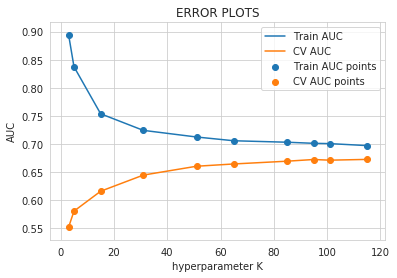

In [0]:
# plotting the error plots
sns.set_style("whitegrid")

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("hyperparameter K")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### From the above error plot we choose K such that, we will have maximum AUC on CV data and the gap between the train and CV is less

In [0]:
for i in range(len(K)):
    print(K[i], cv_auc[i])

3 0.5526993352181997
5 0.5808659782788421
15 0.6162062461918733
31 0.6448970249724831
51 0.6606524696715139
65 0.6647097840055082
85 0.6696266582181064
95 0.6726255482094504
101 0.6714429872891965
115 0.6728207866368126


In [0]:
# best K
best_K_bow = 95

#### 2.1.2 Plotting ROC Curve 

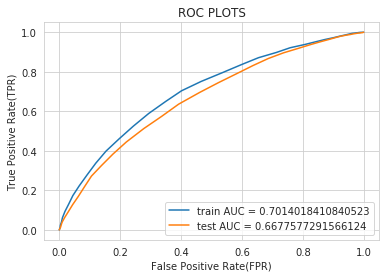

In [0]:
# plot the ROC curve using the besk K value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors = best_K_bow, algorithm='brute')
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = neigh.predict_proba(X_train_bow)[:,1]
y_test_pred = neigh.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

#### 2.1.3 Confusion Matrix

> Note that we are writing our own function for predict with defined threshold we will pick a threshold that will give the least False Positive Rate (FPR) 

In [0]:
# function to determine the optimal threshold value 

def find_best_threshold(thresholds, fpr, tpr):
    ''' this function finds the best threshold '''
    t = thresholds[np.argmax(tpr*(1 - fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1 - fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    ''' This function makes predictions against the best threshold value''' 
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

A. Train Confusion Matrix

In [0]:
# train confusion matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.42274312274590486 for threshold 0.811
Train confusion matrix
[[ 2377  1061]
 [ 7599 11408]]


Text(0.5, 1, 'Confusion Matrix')

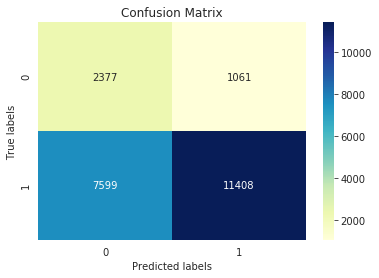

In [0]:
# Visualizing confusion matrix using Seaborn heatmap
# reference: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

B. Test Confusion Matrix

In [0]:
# test confusion matrix
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3867212845985322 for threshold 0.811
Test confusion matrix
[[1536  991]
 [5083 8890]]


Text(0.5, 1, 'Confusion Matrix')

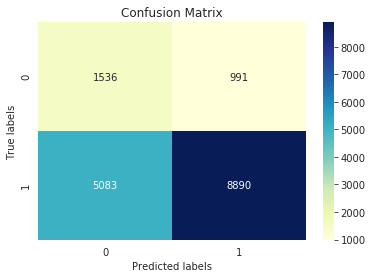

In [0]:
# Visualizing confusion matrix using Seaborn heatmap 
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### 2.2 KNN brute force with TF-IDF featurization of text data

#### 2.2.1 Determining best K using simple cross validation

In [0]:
train_auc = []
cv_auc = [] 
K = [3, 5, 15, 31, 51, 65, 85, 95, 101, 115] # min k causes overfitting, max k causes underfitting

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors = i, algorithm='brute') # takes the k from the ith list value
    neigh.fit(X_train_tfidf, y_train) # fitting the model

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class, not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1] #Return probability estimates for the set 1 train data, for the class label 1 or +ve
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1] #Return probability estimates for the set 1 cv data, for the class label 1 or +ve 
    
    # ROC curve
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores

    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [01:07<10:07, 67.47s/it]


 20%|██        | 2/10 [02:17<09:05, 68.21s/it]


 30%|███       | 3/10 [03:27<08:01, 68.82s/it]


 40%|████      | 4/10 [04:37<06:55, 69.27s/it]


 50%|█████     | 5/10 [05:48<05:47, 69.53s/it]


 60%|██████    | 6/10 [07:00<04:41, 70.25s/it]


 70%|███████   | 7/10 [08:10<03:30, 70.33s/it]


 80%|████████  | 8/10 [09:21<02:20, 70.47s/it]


 90%|█████████ | 9/10 [10:32<01:10, 70.71s/it]


100%|██████████| 10/10 [11:45<00:00, 71.23s/it]




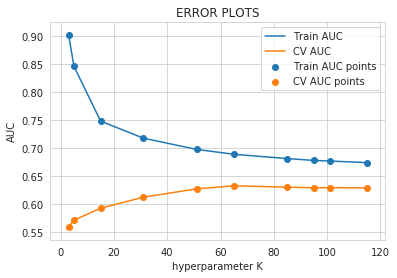

In [0]:
# plotting error plots 

sns.set_style("whitegrid")

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label ='Train AUC points')
plt.scatter(K, cv_auc, label ='CV AUC points')

plt.legend()
plt.xlabel("hyperparameter K")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### From the above error plot we choose K such that, we have maximum AUC on CV data and at same time the gap between the train and CV is less

In [0]:
for i in range(len(K)):
    print(K[i], cv_auc[i])

3 0.5585406280699131
5 0.5707780919782357
15 0.5921044848461307
31 0.6119105908901094
51 0.6268016830359626
65 0.6323178938162768
85 0.62986344535033
95 0.6288409030054736
101 0.6290478393424854
115 0.6285442932047316


In [0]:
# best K
best_K_tfidf = 65

### 2.2.2 Plotting the ROC Curve 

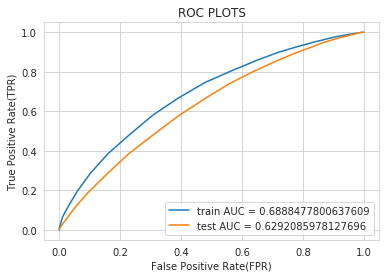

In [0]:
# plot the ROC curve using the besk K value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors = best_K_tfidf, algorithm='brute')
neigh.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = neigh.predict_proba(X_train_tfidf)[:,1]
y_test_pred = neigh.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

### 2.2.3 Confusion Matrix

A. Train Confusion Matrix

In [0]:
# Train confusion matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.40616376202356236 for threshold 0.846
Train confusion matrix
[[ 2092  1346]
 [ 6320 12687]]


Text(0.5, 1, 'Confusion Matrix')

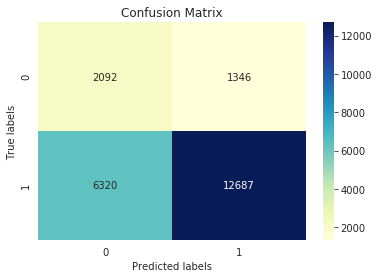

In [0]:
# Visualizing confusion matrix using Seaborn heatmap
# reference -> https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

B. Test Confusion Matrix

In [0]:
# Test confusion matrix
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3513321567562701 for threshold 0.862
Test confusion matrix
[[1534  993]
 [5886 8087]]


Text(0.5, 1, 'Confusion Matrix')

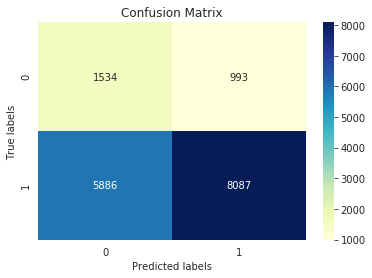

In [0]:
# Visualizing confusion matrix using Seaborn heatmap

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

It was observed that - 

* Both BOW vetorized data & TF-IDF vectorized data perfrom equally well in reducing the number of False positives. The AUC Score of BOW vectorized model(Set 1) was higher as compared to the TF-IDF model because it gave less False Negative (or higher True Positives). 

### 2.3 KNN brute force with AVG-W2V featurization of text data

#### 2.3.1 Determining best K using Simple Cross Validation 

In [0]:
train_auc = []
cv_auc = [] 
K = [3, 5, 15, 31, 51, 65, 85, 95, 101, 115] # min k causes overfitting, max k causes underfitting

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors = i, algorithm='brute') # takes the k from the ith list value
    neigh.fit(X_train_avgw2v, y_train) # fitting the model

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class, not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_avgw2v)[:,1] #Return probability estimates for the set 1 train data, for the class label 1 or +ve
    y_cv_pred =  neigh.predict_proba(X_cv_avgw2v)[:,1] #Return probability estimates for the set 1 cv data, for the class label 1 or +ve 
    
    # ROC curve
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:57<08:34, 57.17s/it]


 20%|██        | 2/10 [01:57<07:43, 57.99s/it]


 30%|███       | 3/10 [02:57<06:50, 58.68s/it]


 40%|████      | 4/10 [03:56<05:53, 58.96s/it]


 50%|█████     | 5/10 [04:57<04:57, 59.45s/it]


 60%|██████    | 6/10 [05:58<03:59, 59.87s/it]


 70%|███████   | 7/10 [06:58<03:00, 60.05s/it]


 80%|████████  | 8/10 [07:59<02:00, 60.27s/it]


 90%|█████████ | 9/10 [09:00<01:00, 60.33s/it]


100%|██████████| 10/10 [10:00<00:00, 60.42s/it]




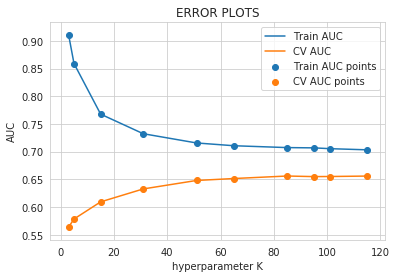

In [0]:
sns.set_style("whitegrid")

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label ='Train AUC points')
plt.scatter(K, cv_auc, label ='CV AUC points')

plt.legend()
plt.xlabel("hyperparameter K")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### From the above error plot we choose K such that we have maximum AUC on CV data and the gap between the train and CV is less

In [0]:
for i in range(len(K)):
    print(K[i], cv_auc[i])

3 0.5639557197228775
5 0.5783050504574041
15 0.6092658543251429
31 0.6326227331437536
51 0.6479074236889544
65 0.6514116886017711
85 0.6559502883613555
95 0.6548961522012187
101 0.6550709902308895
115 0.65584995750285


In [0]:
# best_K
best_K_avgw2v = 85

### 2.3.2 Plotting the ROC Curve 

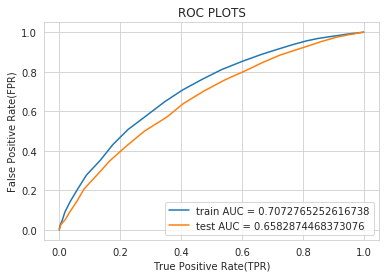

In [0]:
# plot the ROC curve using the besk K value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors = best_K_avgw2v, algorithm = 'brute')
neigh.fit(X_train_avgw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = neigh.predict_proba(X_train_avgw2v)[:,1]
y_test_pred = neigh.predict_proba(X_test_avgw2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

### 2.3.3 Confusion Matrix

A. Train Confusion Matrix

In [0]:
# Train confusion matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4239812998077038 for threshold 0.847
Train confusion matrix
[[ 2247  1191]
 [ 6677 12330]]


Text(0.5, 1, 'Confusion Matrix')

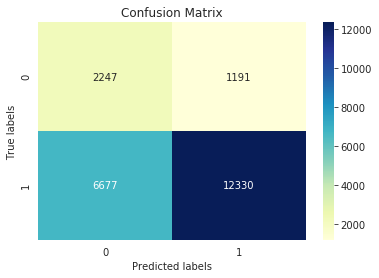

In [0]:
# Visualizing confusion matrix using Seaborn heatmap
# reference -> https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

B. Test Confusion Matrix 

In [0]:
# Test confusion matrix
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3786828297470408 for threshold 0.847
Test confusion matrix
[[1497 1030]
 [5041 8932]]


Text(0.5, 1, 'Confusion Matrix')

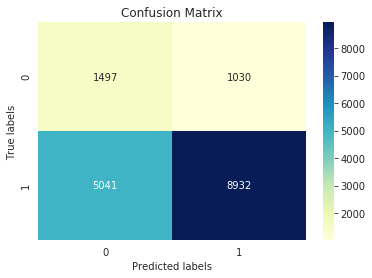

In [0]:
# plotting a heatmap of a confusion matrix 
# Code from: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### 2.4 KNN brute force with TFIDF-W2V featurization of text data

### 2.4.1  Determining best K using simple cross validation 

In [0]:
train_auc = []
cv_auc = [] 
K = [3, 5, 15, 31, 51, 65, 85, 95, 101, 115] # min k causes overfitting, max k causes underfitting

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors = i, algorithm='brute') # takes the k from the ith list value
    neigh.fit(X_train_tfidfw2v, y_train) # fitting the model

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class, not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidfw2v)[:,1] #Return probability estimates for the set 1 train data, for the class label 1 or +ve
    y_cv_pred =  neigh.predict_proba(X_cv_tfidfw2v)[:,1] #Return probability estimates for the set 1 cv data, for the class label 1 or +ve 
    
    # ROC curve
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:57<08:39, 57.75s/it]


 20%|██        | 2/10 [01:57<07:46, 58.36s/it]


 30%|███       | 3/10 [02:57<06:52, 58.89s/it]


 40%|████      | 4/10 [03:58<05:56, 59.34s/it]


 50%|█████     | 5/10 [04:58<04:58, 59.61s/it]


 60%|██████    | 6/10 [05:58<03:59, 59.90s/it]


 70%|███████   | 7/10 [06:59<03:00, 60.17s/it]


 80%|████████  | 8/10 [08:00<02:00, 60.40s/it]


 90%|█████████ | 9/10 [09:01<01:00, 60.41s/it]


100%|██████████| 10/10 [10:01<00:00, 60.47s/it]




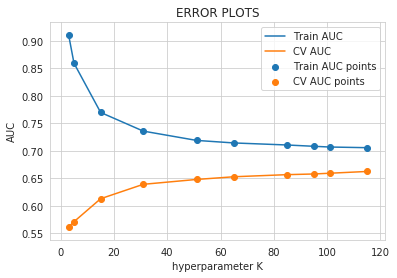

In [0]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label ='Train AUC points')
plt.scatter(K, cv_auc, label ='CV AUC points')

plt.legend()
plt.xlabel("hyperparameter K")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
for i in range(len(K)):
    print(K[i], cv_auc[i])

3 0.5615262436139188
5 0.5710986336210914
15 0.6128844497511404
31 0.6390746821037874
51 0.6479121217712666
65 0.6528072397637615
85 0.6566529512091854
95 0.6578513720985872
101 0.6592271219472082
115 0.6624536955115466


In [0]:
# best_k 
best_K_tfidfw2v = 115

### 2.4.2 Plotting ROC Curve

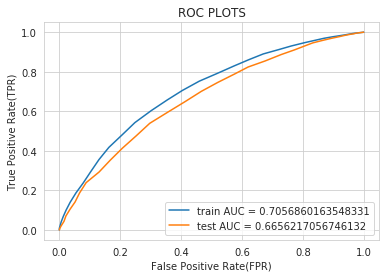

In [0]:
# plot the ROC curve using the besk K value found above 

neigh = KNeighborsClassifier(n_neighbors = best_K_tfidfw2v, algorithm = 'brute')
neigh.fit(X_train_tfidfw2v, y_train)

y_train_pred = neigh.predict_proba(X_train_tfidfw2v)[:,1]
y_test_pred = neigh.predict_proba(X_test_tfidfw2v)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+ str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+ str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

#### 2.4.3 Confusion Matrix


A. Train Confusion Matrix

In [0]:
# train confusion matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.424288433828595 for threshold 0.843
Train confusion matrix
[[ 2220  1218]
 [ 6518 12489]]


Text(0.5, 1, 'Confusion Matrix')

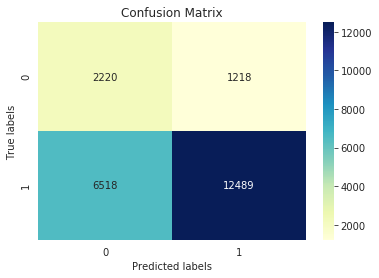

In [0]:
# Visualizing confusion matrix using Seaborn heatmap
# reference -> https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

B. Test Confusion Matrix 

In [0]:
# test confusion matrix
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3833270966271631 for threshold 0.852
Test confusion matrix
[[1628  899]
 [5659 8314]]


Text(0.5, 1, 'Confusion Matrix')

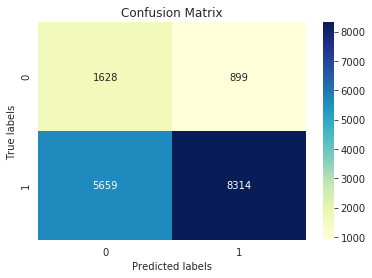

In [0]:
# Visualizing confusion matrix using Seaborn heatmap
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

It is observed that, 

* Among Set 3 model (AVG-W2V) and Set 4 model (TFIDF weighted W2V), TFIDF-W2V vectorized model performs better in reducing False postives. 


* For this problem, our concern was reducing the false postives. If the focus would have been reducing False negatives, then we would have gone with the AVG-W2V (Set 2) model as it gives less false negatives and consequently more True positives! 

### 2.5 Feature selection with `SelectKBest`
KNN brute force on TFIDF vectorized data (set 2)

In [0]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

# If some of the features have negative value then avoid using Pearson's Chi-square. 
# Instead pick another statistic to score your features: sklearn.feature_selection.f_classif computes ANOVA f-value

# Get the 1500 best features
X_train_tfidf_new = SelectKBest(f_classif, k = 1500).fit_transform(X_train_tfidf, y_train)
X_cv_tfidf_new = SelectKBest(f_classif, k = 1500).fit_transform(X_cv_tfidf, y_cv)
X_test_tfidf_new = SelectKBest(f_classif, k = 1500).fit_transform(X_test_tfidf, y_test)

#### 2.5.1 Determinine best K 

In [0]:
train_auc = []
cv_auc = [] 
K = [3, 5, 15, 31, 51, 65, 85, 95, 101, 115] # min k causes overfitting, max k causes underfitting

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors = i, algorithm = 'brute') # takes the k from the ith list value
    neigh.fit(X_train_tfidf_new, y_train) # fitting the model

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class, not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_tfidf_new)[:,1] #Return probability estimates for the set 1 train data, for the class label 1 or +ve
    y_cv_pred =  neigh.predict_proba(X_cv_tfidf_new)[:,1] #Return probability estimates for the set 1 cv data, for the class label 1 or +ve 
    
    # ROC curve
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    train_auc.append(roc_auc_score(y_train, y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))





  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:40<06:03, 40.40s/it]


 20%|██        | 2/10 [01:26<05:36, 42.06s/it]


 30%|███       | 3/10 [02:12<05:04, 43.44s/it]


 40%|████      | 4/10 [02:59<04:26, 44.36s/it]


 50%|█████     | 5/10 [03:46<03:45, 45.12s/it]


 60%|██████    | 6/10 [04:32<03:02, 45.57s/it]


 70%|███████   | 7/10 [05:19<02:17, 45.80s/it]


 80%|████████  | 8/10 [06:05<01:31, 45.99s/it]


 90%|█████████ | 9/10 [06:52<00:46, 46.15s/it]


100%|██████████| 10/10 [07:38<00:00, 46.27s/it]




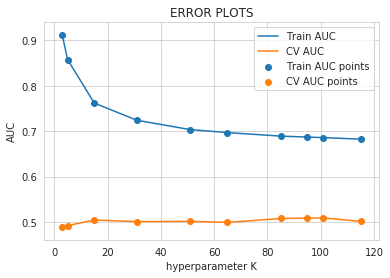

In [0]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label ='Train AUC points')
plt.scatter(K, cv_auc, label ='CV AUC points')

plt.legend()
plt.xlabel("hyperparameter K")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
for i in range(len(K)):
    print(K[i], cv_auc[i])

3 0.5432278751538543
5 0.5442394132656438
15 0.5149322713102806
31 0.48789534362656883
51 0.4719542143185693
65 0.47895117235756834
85 0.4840249436009407
95 0.4877224920343857
101 0.48827554145556307
115 0.4803439172824728


In [0]:
# best_k
best_K_tfidf_feat = 5

#### 2.5.2 Plotting ROC Curve

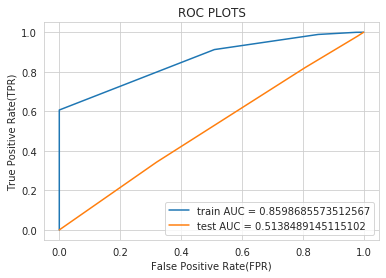

In [0]:
# plot the ROC curve using the besk K value found above 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

neigh = KNeighborsClassifier(n_neighbors = best_K_tfidf_feat, algorithm = 'brute')
neigh.fit(X_train_tfidf_new, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class not the predicted outputs

y_train_pred = neigh.predict_proba(X_train_tfidf_new)[:,1]
y_test_pred = neigh.predict_proba(X_test_tfidf_new)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+ str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+ str(auc(test_fpr, test_tpr)))
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("ROC PLOTS")
plt.legend()
plt.show()

#### 2.5.3 Confusion Matrix

A. Train Confusion Matrix

In [0]:
# Train confusion matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.6066186141947704 for threshold 1.0
Train confusion matrix
[[ 3438     0]
 [ 7477 11530]]


Text(0.5, 1, 'Confusion Matrix')

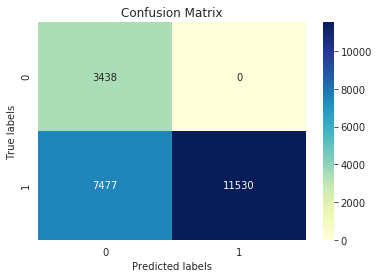

In [0]:
# Visualizing confusion matrix using Seaborn heatmap
# reference -> https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

B. Test Confusion Matrix

In [0]:
# Test confusion matrix
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.23313433553562274 for threshold 1.0
Test confusion matrix
[[1720  807]
 [9187 4786]]


Text(0.5, 1, 'Confusion Matrix')

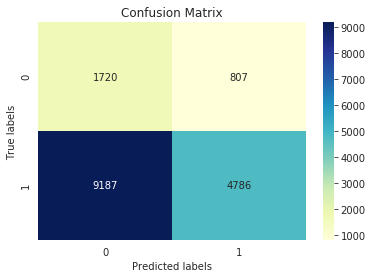

In [0]:
# plotting a heatmap of a confusion matrix 

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, ax = ax, fmt='g', cmap="YlGnBu")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## 3. Conclusion

In [0]:
# Comparision of all models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ("Vectorizer", "Model", "Hyperparameter" ,"AUC_Score")
table.add_row(["BOW", "Brute KNN", 95, 0.667])
table.add_row(["TF-IDF", "Brute KNN", 65, 0.629])
table.add_row(["AVG-W2V", "Brute KNN", 85, 0.658])
table.add_row(["TFIDF-W2v", "Brute KNN", 115, 0.665])
table.add_row(["TFIDF KBest", "Brute KNN", 5, 0.513])

print(table)

+-------------+-----------+----------------+-----------+
|  Vectorizer |   Model   | Hyperparameter | AUC_Score |
+-------------+-----------+----------------+-----------+
|     BOW     | Brute KNN |       95       |   0.667   |
|    TF-IDF   | Brute KNN |       65       |   0.629   |
|   AVG-W2V   | Brute KNN |       85       |   0.658   |
|  TFIDF-W2v  | Brute KNN |      115       |   0.665   |
| TFIDF KBest | Brute KNN |       5        |   0.513   |
+-------------+-----------+----------------+-----------+


By comparing the AUC Scores, we can say that for the given dataset, the model employing BOW Vectorization and the model employing TFIDF-W2V are the best models as they have nearly same highest AUC_Score of 0.667 and 0.665 respectively. 

We had performed this analysis & prediction on the 50k datapoints randomly sampled from the set of 109k datapoints. The performance can be further improved to by considering more datapoints, and features(to some extent).  